In [1]:
import pickle
import scipy.io as spio
import pandas as pd
import numpy as np
import json
import h5py

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
subs = [1, 2, 5, 7]

test_indices = []

for s in subs:
    path = f'/SSD/slava/brain_decoding/nsd/processed_data/subj0{s}/sig_test_sub{s}.pkl'
    test_indices.append( list(pickle.load(open(path, 'rb')).keys()) )
    

In [4]:
test_indices[0] == test_indices[1] == test_indices[2] == test_indices[3]

True

In [5]:
stim_order = loadmat('/SSD/slava/brain_decoding/nsd/data/nsddata/experiments/nsd/nsd_expdesign.mat')
nsd_stiminfo = pd.read_pickle('/SSD/slava/brain_decoding/nsd/data/nsddata/experiments/nsd/nsd_stim_info_merged.pkl')
test_indices = set(test_indices[0])
len(test_indices)

/tmp/ipykernel_33325/2267744726.py:14: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):


982

In [6]:
annotations = "../captions_train2017.json"
coco_dataset = json.load(open(annotations, 'r'))['annotations']

coco_train_ids = set(coco_dataset[i]['image_id'] for i in range(len(coco_dataset)))
len(coco_train_ids)

118287

In [7]:
f_stim = h5py.File('/SSD/slava/brain_decoding/nsd/data/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
stim = f_stim['imgBrick'][:]


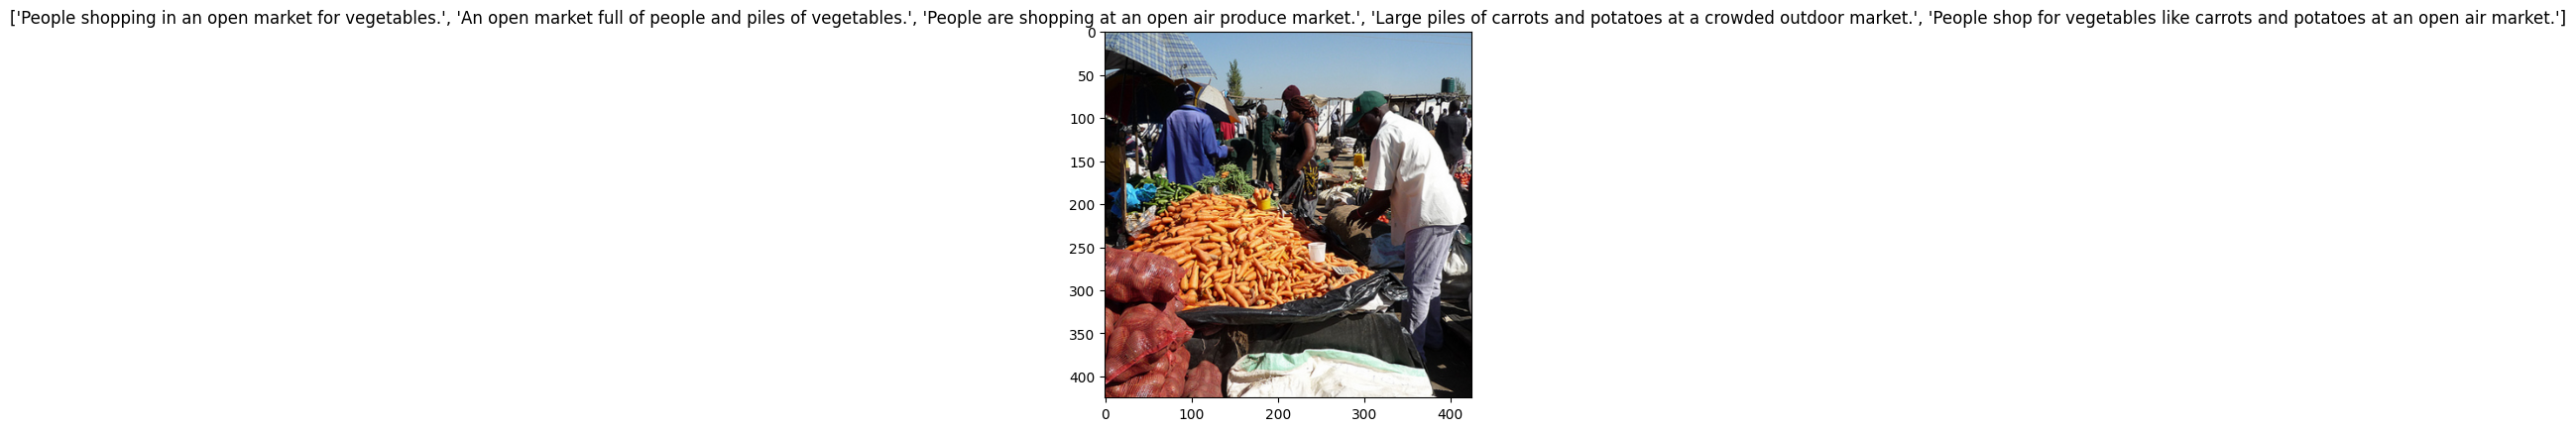

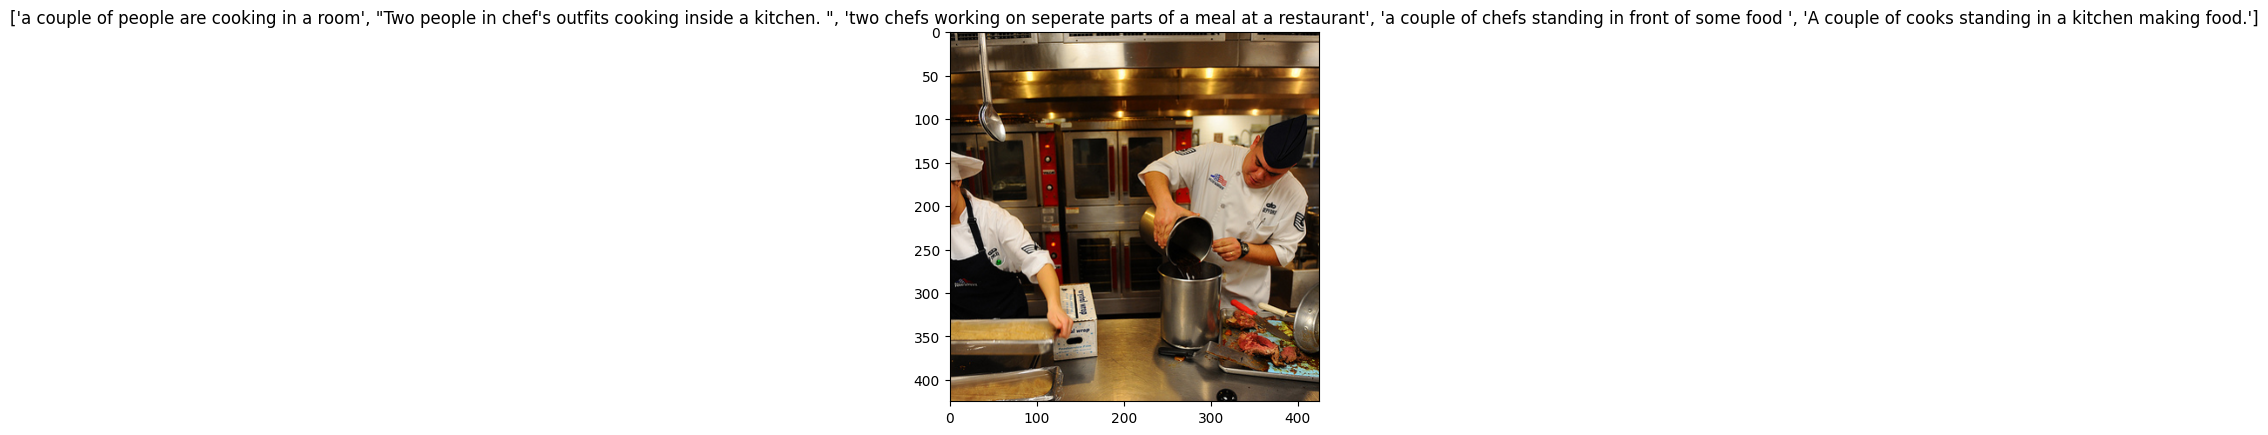

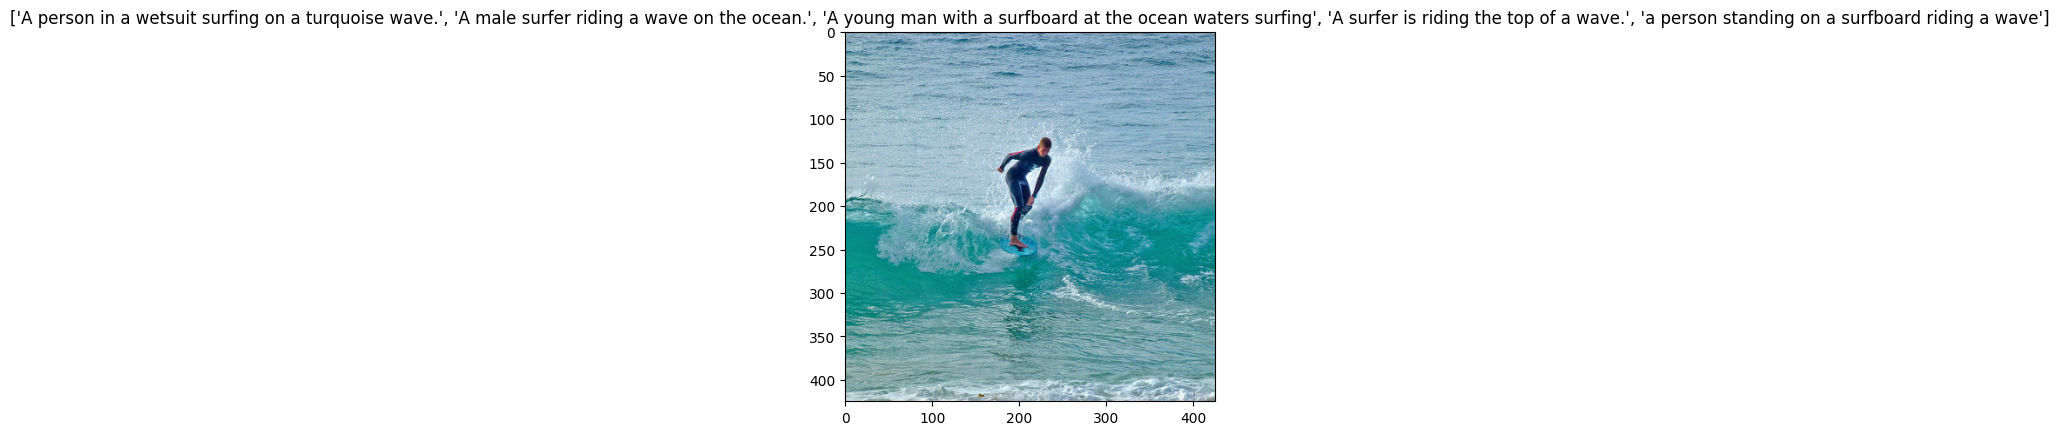

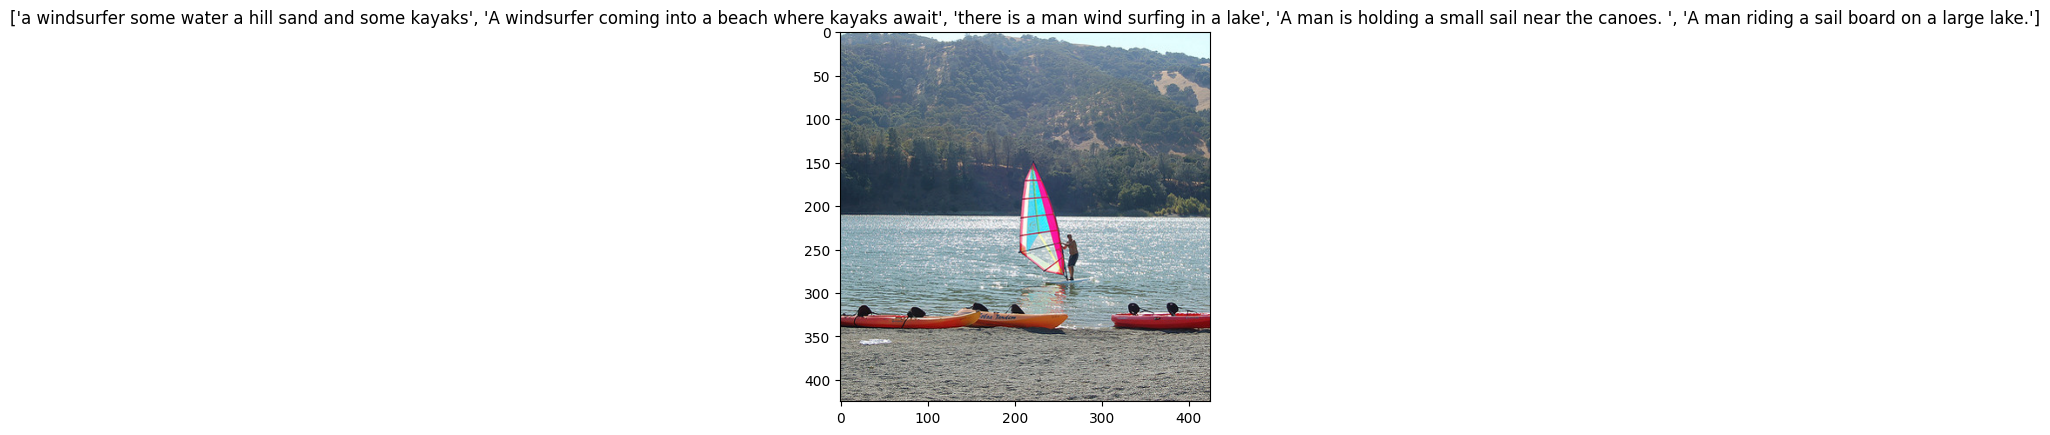

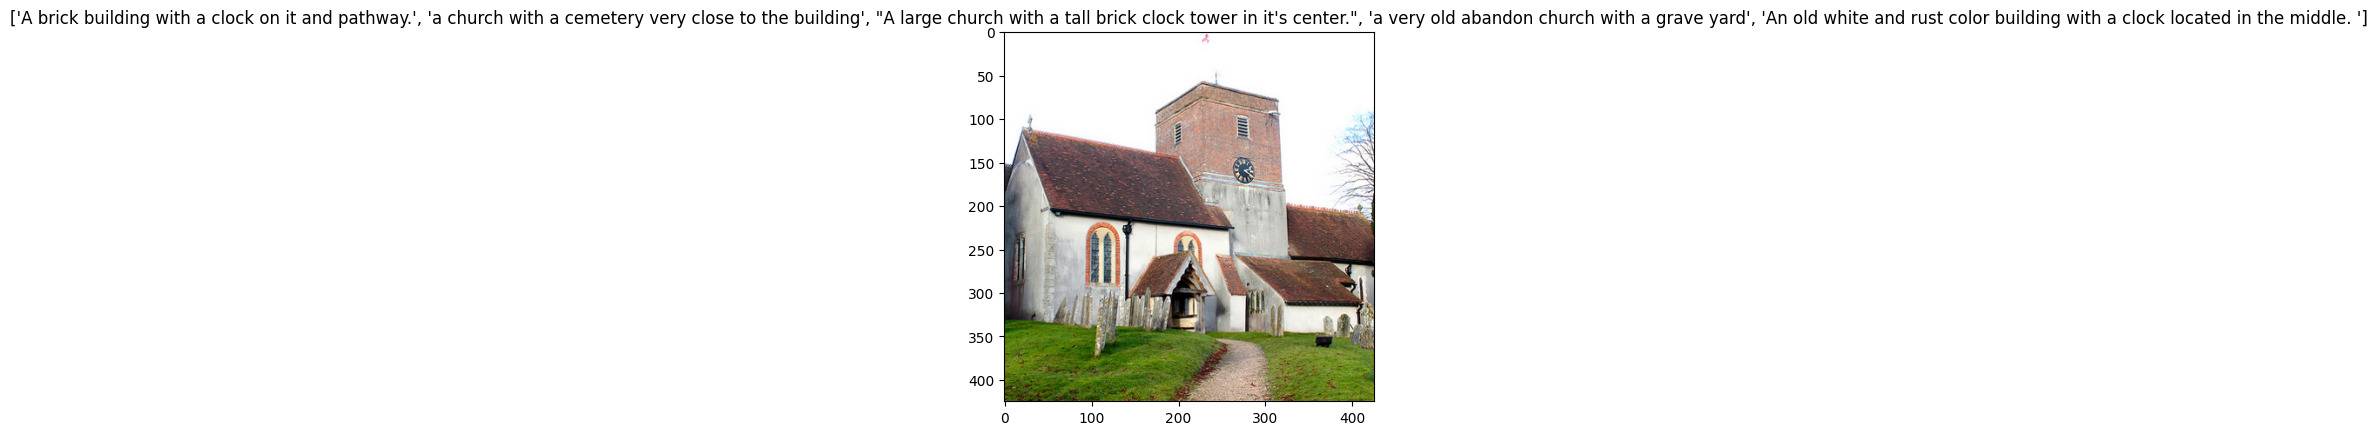

In [8]:
subject_idx  = stim_order['subjectim']

cocoId_set = set()

cocoId = np.array(nsd_stiminfo['cocoId'])[nsd_stiminfo['subject%d'%(1)].astype(bool)]
nsdId = np.array(nsd_stiminfo['nsdId'])[nsd_stiminfo['subject%d'%(1)].astype(bool)]

count = 0

for nsd_i, coco_i in zip(nsdId, cocoId):
    if nsd_i in test_indices:
        cocoId_set.add(coco_i)
        
        if count < 5:
            # plot to ensure correctness
            coco_caption = [coco_dataset[i]['caption'] for i in range(len(coco_dataset))
                            if coco_dataset[i]['image_id']==coco_i]

            plt.figure()
            plt.imshow(stim[nsd_i])
            plt.title(coco_caption)
            plt.show()
        
            count += 1

In [9]:
intersection_num = len(coco_train_ids.intersection(cocoId_set))
total_num = len(test_indices)


print(f'{(intersection_num/total_num) * 100:.2f}% of NSD test data is present in COCO train')

100.00% of NSD test data is present in COCO train
